In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kostrovy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv("data/test.csv")
df.head()

,article,label
0,The president has yet to clarify what victory ...,right
1,"SHARETo hear President Joe Biden tell it, the ...",right
2,SHAREThe mainstream media's honeymoon with Pre...,right
3,"The ""Squad"" makes a demand for which there is ...",right
4,The restraint crowd delivers America's humilia...,right


In [4]:
df.article = df.article.apply(lambda x:x.replace("SHARE",""))
df.head()

,article,label
0,The president has yet to clarify what victory ...,right
1,"To hear President Joe Biden tell it, the Ameri...",right
2,The mainstream media's honeymoon with Presiden...,right
3,"The ""Squad"" makes a demand for which there is ...",right
4,The restraint crowd delivers America's humilia...,right


In [5]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [6]:
def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text


In [7]:
df.article = df.article.apply(clean_text)
df

,article,label
0,president yet clarify victory pandemic looks l...,right
1,hear president joe biden tell american evacuat...,right
2,mainstream medias honeymoon president joe bide...,right
3,squad makes demand military solutionfor better...,right
4,restraint crowd delivers americas humiliation ...,right
...,...,...
3487,washington house senate thursday approved shor...,center
3488,lieutenant colonel stuart scheller marine offi...,center
3489,lieutenant colonel stuart scheller marine offi...,center
3490,two factions president bidens party warring do...,center


In [8]:
df.article = df.article.str.replace('\d+', '')

In [9]:
df.head()

,article,label
0,president yet clarify victory pandemic looks l...,right
1,hear president joe biden tell american evacuat...,right
2,mainstream medias honeymoon president joe bide...,right
3,squad makes demand military solutionfor better...,right
4,restraint crowd delivers americas humiliation ...,right


In [11]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [14]:
tokenizer.fit_on_texts(df.article.values)

In [15]:
word_index = tokenizer.word_index

In [16]:
print(f'Found {len(word_index)} unique tokens')

Found 59479 unique tokens


In [17]:
X = tokenizer.texts_to_sequences(df.article.values)

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences 
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print(f'SHape of data tensor: {X.shape}')

SHape of data tensor: (3492, 250)


In [19]:
Y = pd.get_dummies(df.label.values)
#Y = df.label.values
print(f'Shape of label tensor:', Y.shape)

Shape of label tensor: (3492, 3)


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SpatialDropout1D, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

In [23]:
import tensorflow as tf
from tensorflow.keras import metrics
import numpy as np

In [24]:
seed = 7
np.random.seed(seed)


In [51]:
def buildModel():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
    #model.add(Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(EMBEDDING_DIM, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [52]:
X.shape

(3492, 250)

In [53]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
z = df.label
for train, test in kfold.split(X,z):
    X_train, X_test = X[train], X[test]
    y_train, y_test = z[train], z[test]
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    print(X_train.shape, y_train.shape)
    model = buildModel()
    model.fit(X_train, y_train, epochs=5, batch_size=48, verbose=1)
    scores = model.evaluate(X_test,y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

(2793, 250) (2793, 3)
Epoch 1/5
59/59 [==============================] - 71s 1s/step - loss: 0.6259 - accuracy: 0.7580
Epoch 2/5
59/59 [==============================] - 69s 1s/step - loss: 0.1227 - accuracy: 0.9653
Epoch 3/5
59/59 [==============================] - 68s 1s/step - loss: 0.0321 - accuracy: 0.9918
Epoch 4/5
59/59 [==============================] - 68s 1s/step - loss: 0.0080 - accuracy: 0.9979
Epoch 5/5
59/59 [==============================] - 69s 1s/step - loss: 0.0011 - accuracy: 1.0000
accuracy: 97.42%
(2793, 250) (2793, 3)
Epoch 1/5
59/59 [==============================] - 72s 1s/step - loss: 0.6253 - accuracy: 0.7547
Epoch 2/5
59/59 [==============================] - 70s 1s/step - loss: 0.1755 - accuracy: 0.9291
Epoch 3/5
59/59 [==============================] - 69s 1s/step - loss: 0.0620 - accuracy: 0.9868
Epoch 4/5
59/59 [==============================] - 69s 1s/step - loss: 0.0360 - accuracy: 0.9900
Epoch 5/5
59/59 [==============================] - 68s 1s/step - l

In [54]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

96.36% (+/- 0.74%)


In [30]:
epochs = 5
batch_size = 32
model = buildModel()

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
79/79 [==============================] - 44s 533ms/step - loss: 0.7446 - accuracy: 0.6263 - val_loss: 0.4166 - val_accuracy: 0.7821
Epoch 2/5
79/79 [==============================] - 42s 530ms/step - loss: 0.1665 - accuracy: 0.9515 - val_loss: 0.1390 - val_accuracy: 0.9571
Epoch 3/5
79/79 [==============================] - 42s 538ms/step - loss: 0.0128 - accuracy: 0.9964 - val_loss: 0.1514 - val_accuracy: 0.9679
Epoch 4/5
79/79 [==============================] - 42s 534ms/step - loss: 9.1578e-04 - accuracy: 1.0000 - val_loss: 0.1481 - val_accuracy: 0.9714
Epoch 5/5
79/79 [==============================] - 43s 539ms/step - loss: 3.1694e-04 - accuracy: 1.0000 - val_loss: 0.1457 - val_accuracy: 0.9750


In [97]:
accr = model.evaluate(X_test, y_test)
print(f'Test set \n Loss {accr[0]:0.3f} Accuracy {accr[1]:0.3f}')

22/22 [==============================] - 1s 53ms/step - loss: 0.1053 - categorical_accuracy: 0.9700
Test set 
 Loss 0.105 Accuracy 0.970


In [87]:
import matplotlib.pyplot as plt

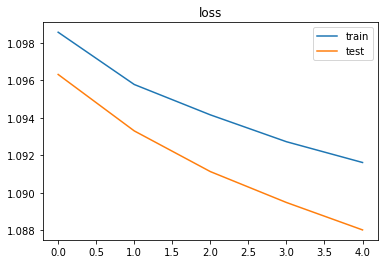

In [88]:
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

KeyError: 'accuracy'

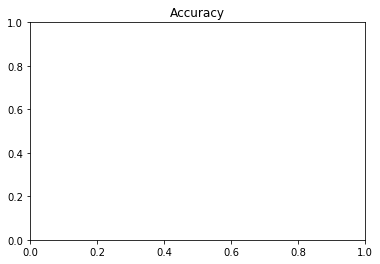

In [89]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
from sklearn.pipeline import Pipeline